In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc2


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-04-12 14:57:43--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 2a00:1450:400c:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-04-12 14:57:43 (94.7 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



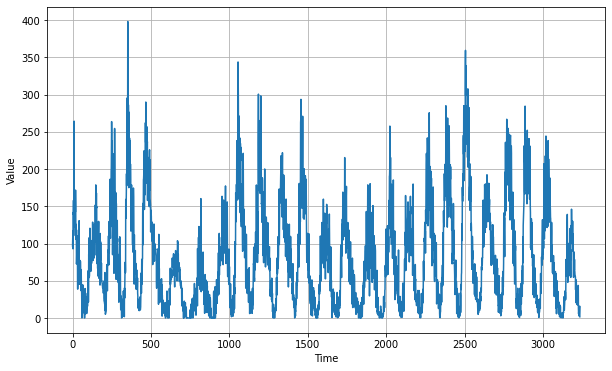

In [4]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

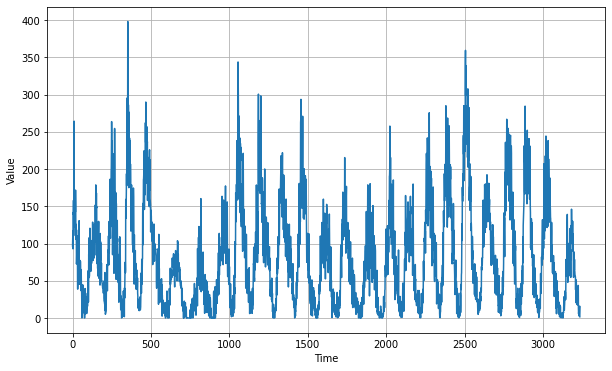

In [5]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.GRU(64, return_sequences=True),
  tf.keras.layers.GRU(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 1s 42ms/step - loss: 153.0825 - mae: 153.3976 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 1s 50ms/step - loss: 149.1448 - mae: 149.5064 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 1s 47ms/step - loss: 143.3259 - mae: 143.8229 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 1s 49ms/step - loss: 136.8521 - mae: 137.1696 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 1s 44ms/step - loss: 129.6877 - mae: 129.9977 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 1s 47ms/step - loss: 122.3929 - mae: 122.6146 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 1s 49ms/step - loss: 114.7373 - mae: 115.3692 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 1s 53ms/step - loss: 108.3615 - m

(1e-08, 0.0001, 0.0, 60.0)

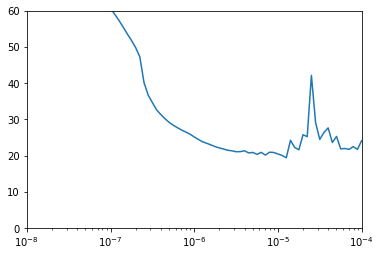

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.GRU(60, return_sequences=True),
  tf.keras.layers.GRU(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 1s 26ms/step - loss: 42.2305 - mae: 42.9272
Epoch 2/500
30/30 [==============================] - 1s 27ms/step - loss: 27.0568 - mae: 27.5645
Epoch 3/500
30/30 [==============================] - 1s 26ms/step - loss: 29.2698 - mae: 29.6836
Epoch 4/500
30/30 [==============================] - 1s 26ms/step - loss: 26.4348 - mae: 26.9703
Epoch 5/500
30/30 [==============================] - 1s 25ms/step - loss: 24.6426 - mae: 25.1507
Epoch 6/500
30/30 [==============================] - 1s 24ms/step - loss: 22.9185 - mae: 23.4434
Epoch 7/500
30/30 [==============================] - 1s 25ms/step - loss: 24.6435 - mae: 25.1672
Epoch 8/500
30/30 [==============================] - 1s 25ms/step - loss: 24.8807 - mae: 25.3852
Epoch 9/500
30/30 [==============================] - 1s 24ms/step - loss: 24.1044 - mae: 24.6243
Epoch 10/500
30/30 [==============================] - 1s 27ms/step - loss: 23.0903 - mae: 23.5775
Epoch 11/500
30/30 [=========

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

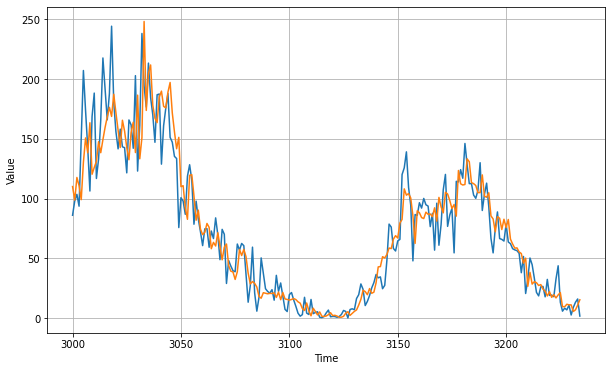

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

14.346479

<Figure size 432x288 with 0 Axes>

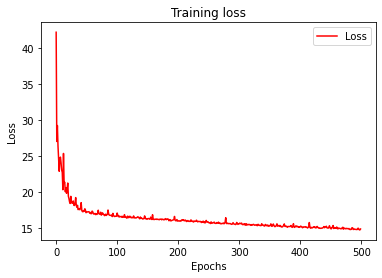

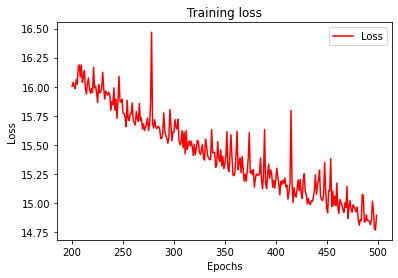

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [16]:
print(rnn_forecast)

[110.03738     98.66942    117.64636    110.72705     99.06749
 130.4271     150.7471     138.27637    163.45534    120.3499
 125.97084    131.16223    147.60406    138.38771    149.30008
 159.54596    168.29967    176.38016    168.75497    187.33047
 171.83415    157.49403    142.7158     165.55975    156.43604
 142.7293     132.49416    155.38545    163.91219    138.50694
 186.5706     133.27896    151.06526    248.26424    173.79515
 204.81805    211.83763    178.15128    167.23265    163.57028
 184.96033    189.93526    177.19272    175.88269    189.09212
 197.18463    171.73596    155.87782    141.69014    151.24127
 109.94627    110.7546      92.330086    82.619736   119.44851
 119.96449    102.22249     81.845184    90.30476     74.37639
  69.77976     71.76239     79.13811     75.82682     58.003647
  63.287483    60.258778    71.38524     59.737312    48.68049
  59.329372    61.90155     43.886097    39.201946    38.51308
  32.27551     38.746902    57.40581     52.28173     5